In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from esem import gp_model
from esem.utils import get_random_params
from sklearn.metrics import mean_squared_error, r2_score
import gpflow

2025-07-11 12:23:57.208687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 12:23:58.964563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752258239.282186   92173 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752258239.336242   92173 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752258240.292435   92173 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(5)

# Setup your client
client = Client(cluster)

In [2]:
import sys
sys.path.append('~/leap-carbon-ppe/')
from linnia_functions import *

In [3]:
filename = '/glade/derecho/scratch/linnia/leap-reu-mf-2025/ctsm6ppe_amean_1850-2023.nc'
dataset = xr.open_dataset(filename)
ds = dataset.isel(ens =slice(1,1494))

In [4]:
ppe_params = pd.read_csv('/glade/derecho/scratch/linnia/leap-reu-mf-2025/ctsm6lhc_params.csv').drop(columns='member')

In [9]:
da = ds.TLAI_gridded_amean.sel(year=slice(2000,2020)).mean(dim='year')
lai_global = global_mean(da)

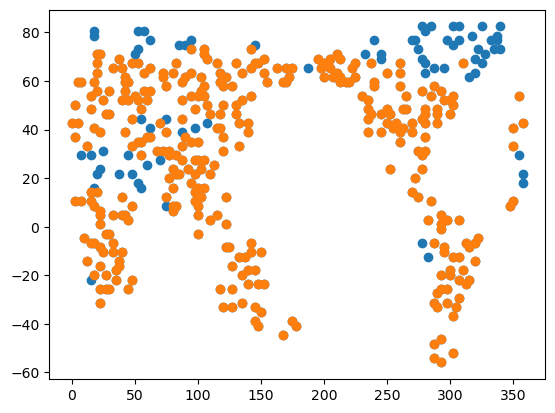

In [46]:
plt.scatter(ds.grid1d_lon,ds.grid1d_lat)
plt.scatter(ds.grid1d_lon.sel(gridcell=grid_ix),ds.grid1d_lat.sel(gridcell=grid_ix))

### Spatial temporal MLP

In [36]:
def amean(da):
    #annual mean of monthly data
    m  = da['time.daysinmonth']
    cf = 1/365
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

In [25]:
# first lets subset only vegetated gridcells (not the ones over the greenland ice sheet for example)
lai_mean = ds.TLAI_gridded_amean.sel(year=2000) 
grid_ix = lai_mean.where(lai_mean > 0.5, drop=True)['gridcell']
da = ds.EFLX_LH_TOT_gridded_amean.sel(year=slice('1901','2000'),gridcell=grid_ix)

In [37]:
met = xr.open_dataset('/glade/derecho/scratch/linnia/leap-reu-mf-2025/CRUJRA_met_monthly_1850-2023.nc')
met['PREC'] = met['RAIN']+met['SNOW']

tbot_mx = met.TBOT.resample(time='1Y').max(dim='time')
tbot_mn = met.TBOT.resample(time='1Y').min(dim='time')
met['TBOT_RANGE'] = tbot_mx - tbot_mn
met['VPD_MIN'] = met.VPD.resample(time='1Y').min(dim='time')

met_vars = ['PREC','TBOT','TBOT_RANGE','VPD_MIN','FLDS','FSDS','WIND','QBOT']
met_data = amean(met[met_vars]).sel(year=slice('1901','2000'),gridcell=grid_ix)

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


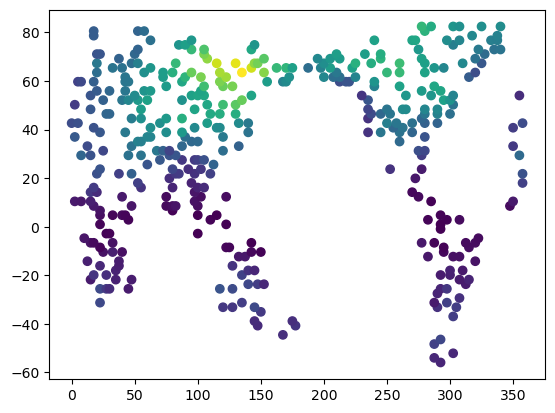

In [59]:

plt.scatter(ds.grid1d_lon,ds.grid1d_lat,c=tbot_rng.isel(time=173))

In [ ]:
plt.scatter(ds.grid1d_lon,ds.grid1d_lat,c=tbot_.isel(time=173))

In [38]:
# Get dimension sizes
n_ens = da.sizes['ens']
n_year = da.sizes['year']
n_grid = da.sizes['gridcell']
n_param = np.shape(ppe_params)[1]

In [39]:
Y = da.values.reshape(-1)  # shape: [n_ens * n_year * n_gridcell]

KeyboardInterrupt: 

In [20]:
# build X
P = ppe_params.values  
P_expanded = np.repeat(P[:, None, :], n_year * n_grid, axis=1).reshape(-1, n_param) 

M = met_data.values.reshape(n_year * n_grid, -1)  # [n_year * n_grid, n_meteo]
M_tiled = np.tile(M, (n_ens, 1))  # [N, n_meteo]


In [ ]:
years = da['year'].values
year_feature = np.tile(np.repeat(years, n_grid), n_ens).reshape(-1, 1)  # [N, 1]


In [ ]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1)).flatten()


In [ ]:
# train simple MLP


X_train, X_val, Y_train, Y_val = train_test_split(
    X_scaled, Y_scaled, test_size=0.1, random_state=42
)

n_features = X.shape[1]

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)  # scalar output: soil moisture
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [ ]:
# train
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=4096,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


In [ ]:
# eval
Y_pred_scaled = model.predict(X_val).flatten()
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_true = scaler_Y.inverse_transform(Y_val.reshape(-1, 1)).flatten()

rmse = np.sqrt(np.mean((Y_true - Y_pred)**2))
print(f'Validation RMSE: {rmse:.3f}')